# Prune DistillBERT

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random

import torch
import torch.nn as nn

from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm


In [2]:
def reseed(seed, env=None):
    '''
        Sets the seed for reproducibility 

        When @param env is provided, also sets the 
        random number generataor of the gym environment 
        to this particular seed
    '''
    torch.manual_seed(seed)
    random.seed(seed)
    np.random.seed(seed)
    
    if env is not None: 
        env.unwrapped._np_random = gym.utils.seeding.np_random(seed)[0]


### Load Dataset

https://huggingface.co/datasets/dair-ai/emotion


In [3]:
from datasets import load_dataset
from transformers import DataCollatorWithPadding
from transformers import DistilBertTokenizer, DistilBertModel

raw_dataset = load_dataset("dair-ai/emotion")
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')

C:\Users\kathe\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\datasets\load.py:1486: FutureWarning: The repository for dair-ai/emotion contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/dair-ai/emotion
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


### Make Dataloader / Data Preprocessing

In [4]:
from torch.utils.data import DataLoader

def tokenize_function(example):
    return tokenizer(example['text'], truncation=True, padding=True, return_tensors="pt", max_length=50)

tokenized_datasets = raw_dataset.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

def one_hot_encode(x, max_len=6):
    result = torch.zeros(max_len)
    result[x] = 1
    return result

def collate_fn(batch):
    input_ids = [torch.tensor(item['input_ids']) for item in batch]
    attention_mask = [torch.tensor(item['attention_mask']) for item in batch]
    labels = [one_hot_encode(item['label']) for item in batch]

    # Convert lists to tensors
    input_ids = torch.stack(input_ids)
    attention_mask = torch.stack(attention_mask)
    labels = torch.stack(labels)

    return {"input_ids": input_ids, "attention_mask": attention_mask, "labels": labels}

train_dataloader = DataLoader(tokenized_datasets["train"], shuffle=True, batch_size=8, collate_fn=collate_fn)
eval_dataloader = DataLoader(tokenized_datasets["test"], batch_size=8, collate_fn=collate_fn)

### DistillBERT Class

In [5]:
class DistilBERTClass(torch.nn.Module):
    """
    Code for parts of the initializations and from the forward pass were taken from: 
    https://colab.research.google.com/github/DhavalTaunk08/Transformers_scripts/blob/master/Transformers_multilabel_distilbert.ipynb#scrollTo=FeftvDhjDSPp
    
    Taunk, Dhaval. “Finetune DistilBERT for multi-label text classsification task.” Analytics Vidhya, Medium, 16 Sep. 2020
    """
    

    def __init__(self):
        super(DistilBERTClass, self).__init__()
        self.l1 = DistilBertModel.from_pretrained("distilbert-base-uncased")
        self.pre_classifier = torch.nn.Linear(768, 768)
        self.dropout = torch.nn.Dropout(0.1)
        self.classifier = torch.nn.Linear(768, 6)

        self.loss_history = []
        self.pruning_layers = ["l1.transformer.layer.0.ffn.lin1.weight", "l1.transformer.layer.0.ffn.lin1.bias",
        "l1.transformer.layer.0.ffn.lin2.weight", "l1.transformer.layer.0.ffn.lin2.bias",
        "l1.transformer.layer.1.ffn.lin1.weight", "l1.transformer.layer.1.ffn.lin1.bias",
        "l1.transformer.layer.1.ffn.lin2.weight", "l1.transformer.layer.1.ffn.lin2.bias",
        "l1.transformer.layer.2.ffn.lin1.weight", "l1.transformer.layer.2.ffn.lin1.bias",
        "l1.transformer.layer.2.ffn.lin2.weight", "l1.transformer.layer.2.ffn.lin2.bias",
        "l1.transformer.layer.3.ffn.lin1.weight", "l1.transformer.layer.3.ffn.lin1.bias", 
        "l1.transformer.layer.3.ffn.lin2.weight", "l1.transformer.layer.3.ffn.lin2.bias",
        "l1.transformer.layer.4.ffn.lin1.weight", "l1.transformer.layer.4.ffn.lin1.bias",
        "l1.transformer.layer.4.ffn.lin2.weight", "l1.transformer.layer.4.ffn.lin2.bias",
        "l1.transformer.layer.5.ffn.lin1.weight", "l1.transformer.layer.5.ffn.lin1.bias",
        "l1.transformer.layer.5.ffn.lin2.weight", "l1.transformer.layer.5.ffn.lin2.bias"]
        self.pretrained_weights_dict = self.get_param_dict()

    def forward(self, input_ids, attention_mask):
        output_1 = self.l1(input_ids=input_ids, attention_mask=attention_mask)
        hidden_state = output_1[0]
        pooler = hidden_state[:, 0]
        pooler = self.pre_classifier(pooler)
        pooler = torch.nn.Tanh()(pooler)
        pooler = self.dropout(pooler)
        output = self.classifier(pooler)
        return output
    
    def get_param_list(self):
        """
        Get weights as numpy array
        """
        params = []
        for i, p in enumerate(self.named_parameters()):
            if p[0] in self.pruning_layers:
                params.extend(p[1].view(-1).cpu().detach().numpy())
        return np.array(params)

    def get_param_dict(self):
        """
        Get weights by layer as dictionary
        """
        params = {}
        for i, p in enumerate(self.named_parameters()):
            if p[0] in self.pruning_layers:
                temp = torch.clone(p[1])
                params[p[0]] = temp
        return params

def train(model, data_loader, optimizer, criterion, num_epoch=1):
    
    model.train()
    for _ in range(num_epoch):
        for i, batch in tqdm(enumerate(data_loader, 0)):
            input_ids = batch['input_ids'].to(device, dtype = torch.long)
            mask = batch['attention_mask'].to(device, dtype = torch.long)
            targets = batch['labels'].to(device, dtype = torch.float)

            outputs = model(input_ids, mask)

            optimizer.zero_grad()
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            if i%100==0:
                model.loss_history.append(loss.item())
                # print(f'Loss:  {loss.item()}')

        torch.save(model, 'distilbert.bin')

def evaluate(model, data_loader, criterion, plot=True):
    model.eval()
    predictions = []
    targets = []
    losses = []
    for batch in tqdm(data_loader):
        input_ids = batch['input_ids'].to(device, dtype = torch.long)
        mask = batch['attention_mask'].to(device, dtype = torch.long)
        target = batch['labels'].to(device, dtype = torch.float)

        outputs = model(input_ids, mask)
        loss = criterion(outputs, target)
        losses.append(loss.item())
        
        # preds = outputs.argmax(dim=1)
        # preds = preds.cpu().detach().numpy().tolist()

        predictions.extend(outputs.cpu().detach().numpy().tolist())
        targets.extend(target.cpu().detach().numpy().tolist())
    
    pred_labels = np.array(predictions).argmax(axis=1)
    target_labels = np.array(targets).argmax(axis=1)
    prop_correct = np.mean(pred_labels == target_labels)
    avg_loss = np.mean(losses)

    if plot:
        plt.hist(target_labels, alpha=0.2)
        plt.hist(pred_labels, alpha=0.2)
        plt.legend(labels=["True", "Predicted"])
        plt.title(f"Average {str(criterion)} : {round(avg_loss, 4)}, % Correct: {round(100*prop_correct, 4)}")
        plt.show()

    return predictions, targets, pred_labels, target_labels, prop_correct, avg_loss


In [ ]:
seed = 9
reseed(seed)

model = DistilBERTClass()
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

optimizer = torch.optim.Adam(params =  model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()#torch.nn.BCEWithLogitsLoss()

untrained_weights_list = model.get_param_list()

  0%|          | 0/2000 [00:00<?, ?it/s]

100%|██████████| 2000/2000 [00:44<00:00, 45.24it/s]


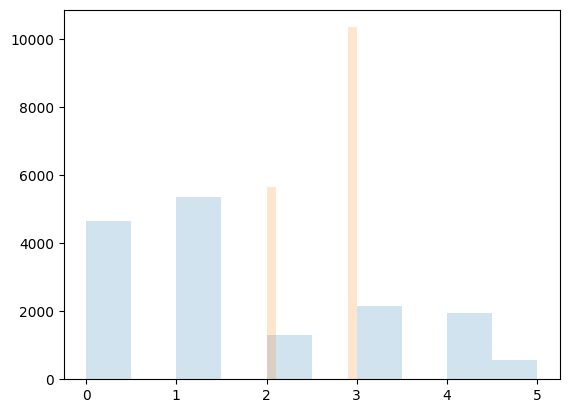

In [33]:
untrained_predictions, untrained_targets, untrained_losses = evaluate(model, eval_dataloader, criterion)

untrained_pred_labels = np.array(untrained_predictions).argmax(axis=1)
untrained_target_labels = np.array(untrained_targets).argmax(axis=1)

plt.hist(untrained_target_labels, alpha=0.2)
plt.hist(untrained_pred_labels, alpha=0.2)
plt.show()

In [62]:


train(model, train_dataloader, optimizer, criterion, 1)

trained_weights_list = model.get_param_list()

2000it [02:14, 14.89it/s]


In [81]:
random_idx = np.random.choice(list(range(len(trained_weights_list))), 1000)

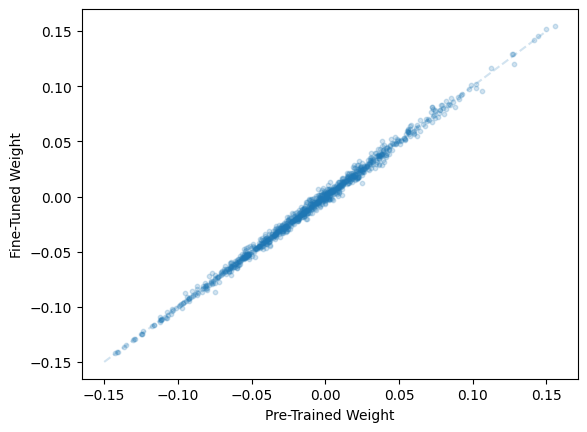

In [138]:
plt.scatter(untrained_weights_list[random_idx], trained_weights_list[random_idx], s=10, alpha=0.2)
plt.xlabel("Pre-Trained Weight")
plt.ylabel("Fine-Tuned Weight")
plt.plot([-0.15, 0.15], [-0.15, 0.15], alpha=0.2, linestyle="--")

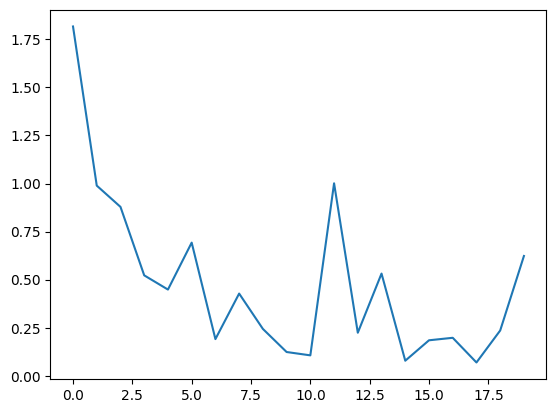

In [63]:
loss_history = model.loss_history
plt.plot(loss_history)

100%|██████████| 2000/2000 [00:44<00:00, 44.71it/s]


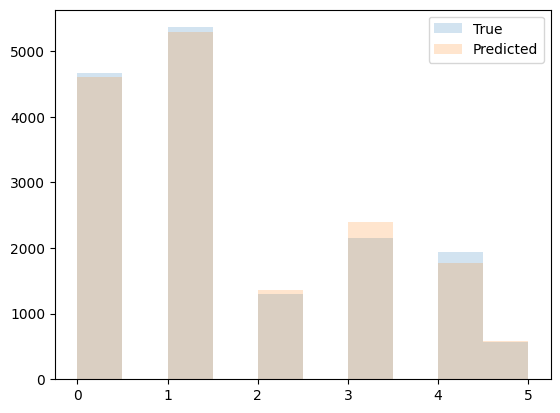

In [64]:
trained_predictions, trained_targets, trained_losses = evaluate(model, eval_dataloader, criterion)

trained_pred_labels = np.array(trained_predictions).argmax(axis=1)
trained_target_labels = np.array(trained_targets).argmax(axis=1)

plt.hist(trained_target_labels, alpha=0.2)
plt.hist(trained_pred_labels, alpha=0.2)
plt.legend(labels=["True", "Predicted"])

In [65]:
torch.save(model, 'distilbert.pt')

In [175]:
def get_masked_model(model, q=0.1, type="movement"):
    
    pretrained_weights_dict = model.pretrained_weights_dict
    fine_tuned_weights_dict = model.get_param_dict()
    state_dict = model.state_dict()

    device = pretrained_weights_dict[list(pretrained_weights_dict.keys())[0]].device

    mask_list = []
    score_list = []

    param_count = 0
    masked_param_count = 0
    for k in pretrained_weights_dict.keys():
        if type == "movement":
            diff = fine_tuned_weights_dict[k].to(device) - pretrained_weights_dict[k].to(device)
            score = diff * torch.sign(pretrained_weights_dict[k])
        elif type == "random":
            score = torch.rand_like(fine_tuned_weights_dict[k]).to(device)
        else: # magnitude pruning
            score = torch.abs(fine_tuned_weights_dict[k].to(device))

        flat_score = score.flatten()
        threshold = torch.quantile(flat_score, q)
        mask = score > threshold

        state_dict[k] = mask * state_dict[k].to(device)

        param_count += len(flat_score)
        masked_param_count += torch.sum(mask.flatten())

        mask_list.extend(mask.flatten().cpu().detach().numpy())
        score_list.extend(flat_score.cpu().detach().numpy())
    
    percent_weight_removed = 1 - masked_param_count / param_count

    model.load_state_dict(state_dict)

    return model, percent_weight_removed.item(), np.array(mask_list), np.array(score_list)



In [126]:

masked_model = torch.load('distilbert.pt')
trained_weights_list = masked_model.get_param_list()
movement_masked_model, movement_percent_weight_removed, movement_mask_list, movement_score_list = get_masked_model(masked_model, 0.1)
masked_finetuned_weights_list = masked_model.get_param_list()
movement_pruned_weights_list = trained_weights_list[np.array(movement_mask_list)]

In [127]:
masked_model = torch.load('distilbert.pt')
trained_weights_list = masked_model.get_param_list()
magnitude_masked_model, magnitude_percent_weight_removed, magnitude_mask_list, magnitude_score_list = get_masked_model(masked_model, 0.1, type="magnitude")
masked_finetuned_weights_list = masked_model.get_param_list()
magnitude_pruned_weights_list = trained_weights_list[np.array(magnitude_mask_list)]

In [ ]:
masked_model = torch.load('distilbert.pt')
trained_weights_list = masked_model.get_param_list()
magnitude_masked_model, magnitude_percent_weight_removed, magnitude_mask_list, magnitude_score_list = get_masked_model(masked_model, 0.1, type="random")
masked_finetuned_weights_list = masked_model.get_param_list()
magnitude_pruned_weights_list = trained_weights_list[np.array(magnitude_mask_list)]

<Axes: ylabel='Density'>

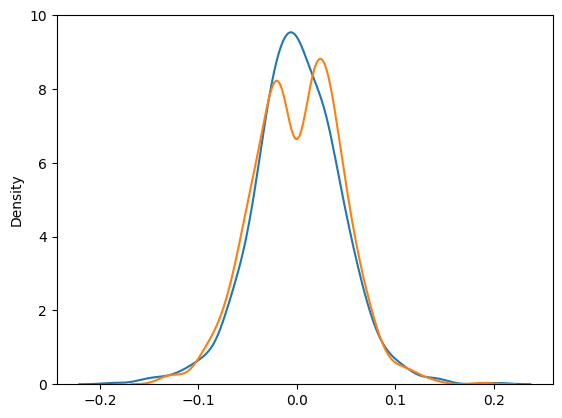

In [174]:
random_idx = np.random.choice(list(range(len(movement_pruned_weights_list))), 1000)
sns.kdeplot(movement_pruned_weights_list[random_idx])

random_idx = np.random.choice(list(range(len(magnitude_pruned_weights_list))), 1000)
sns.kdeplot(magnitude_pruned_weights_list[random_idx])

In [56]:
import seaborn as sns

<Axes: ylabel='Density'>

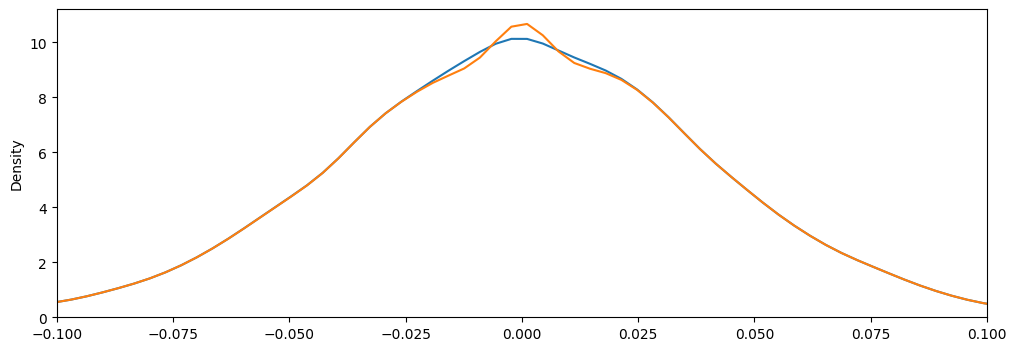

In [104]:
plt.figure(figsize=(12,4))
plt.xlim((-0.1, 0.1))
random_idx = np.random.choice(list(range(len(trained_weights_list))), 10000)
sns.kdeplot(trained_weights_list[random_idx])
sns.kdeplot(masked_finetuned_weights_list[random_idx])

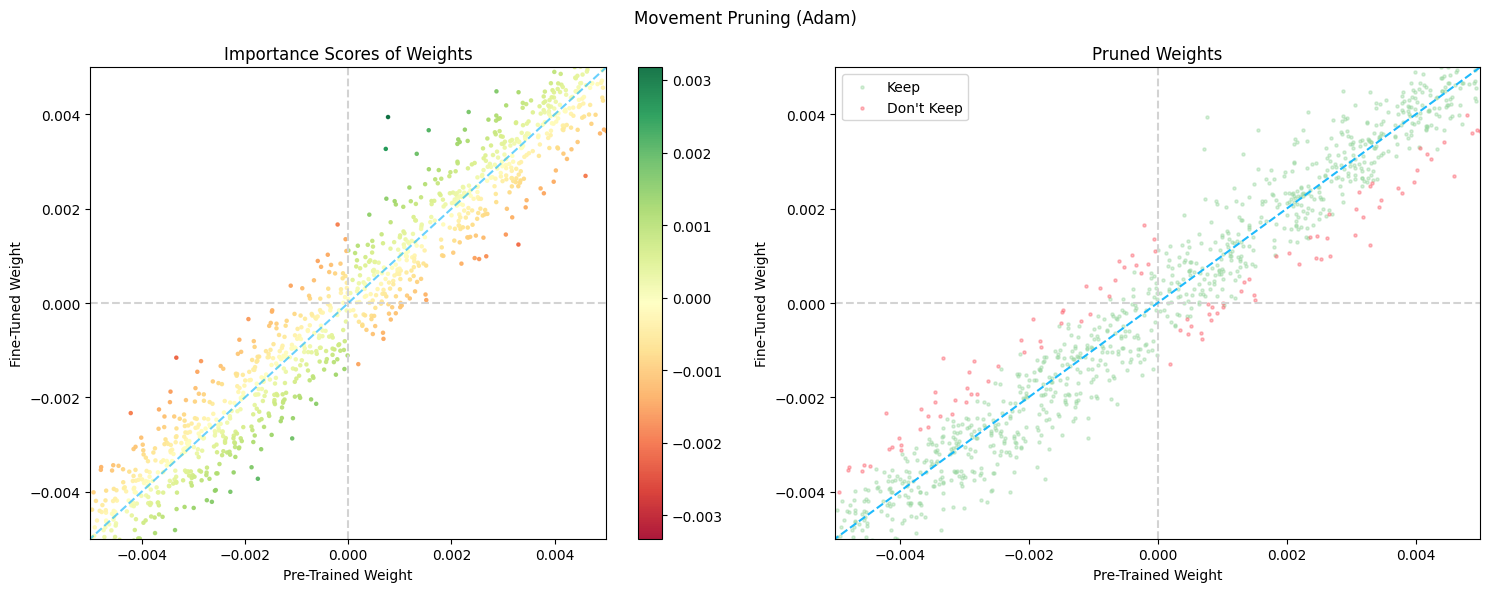

In [173]:
x_subset = untrained_weights_list[random_idx]
y_subset = trained_weights_list[random_idx]
mask_subset = movement_mask_list[random_idx]
score_subset = movement_score_list[random_idx]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(x_subset, y_subset, s=5, alpha=0.9, c=score_subset, cmap='RdYlGn')
axs[0].axvline(x=0, color='lightgrey', linestyle='--')
axs[0].axhline(y=0, color='lightgrey', linestyle='--')
axs[0].set_xlabel("Pre-Trained Weight")
axs[0].set_ylabel("Fine-Tuned Weight")
axs[0].set_xlim((-0.005, 0.005))
axs[0].set_ylim((-0.005, 0.005))
axs[0].plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.6, color="#05b2fc", linestyle="--")
axs[0].set_title("Importance Scores of Weights")
fig.colorbar(axs[0].collections[0], ax=axs[0])

axs[1].scatter(x_subset[mask_subset], y_subset[mask_subset], s=5, alpha=0.4, color="#98d69f")
axs[1].scatter(x_subset[~mask_subset], y_subset[~mask_subset], s=5, alpha=0.4,color="#fc5b68")
axs[1].axvline(x=0, color='lightgrey', linestyle='--')
axs[1].axhline(y=0, color='lightgrey', linestyle='--')
axs[1].set_xlabel("Pre-Trained Weight")
axs[1].set_ylabel("Fine-Tuned Weight")
axs[1].set_xlim((-0.005, 0.005))
axs[1].set_ylim((-0.005, 0.005))
axs[1].plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.9, color="#05b2fc", linestyle="--")
axs[1].legend(labels=["Keep", "Don't Keep"])
axs[1].set_title("Pruned Weights")

plt.suptitle("Movement Pruning (Adam)")

plt.tight_layout()
plt.show()


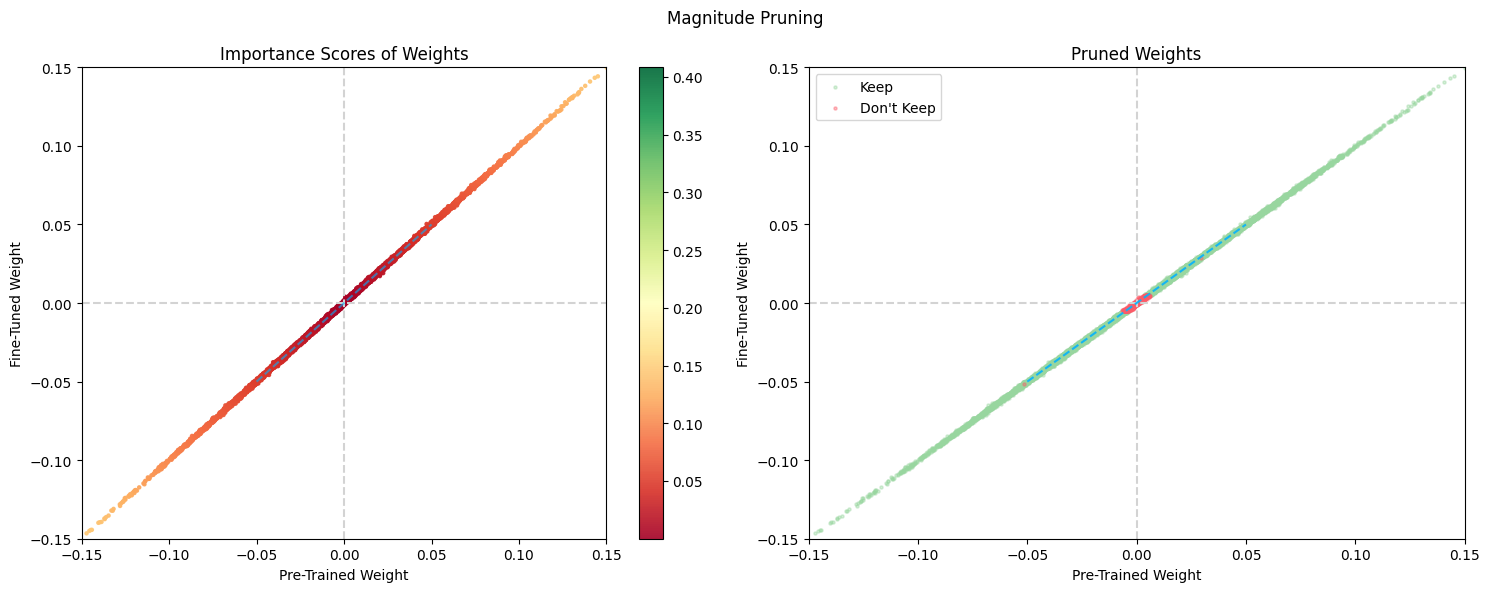

In [171]:
x_subset = untrained_weights_list[random_idx]
y_subset = trained_weights_list[random_idx]
mask_subset = magnitude_mask_list[random_idx]
score_subset = magnitude_score_list[random_idx]

fig, axs = plt.subplots(1, 2, figsize=(15, 6))

axs[0].scatter(x_subset, y_subset, s=5, alpha=0.9, c=score_subset, cmap='RdYlGn')
axs[0].axvline(x=0, color='lightgrey', linestyle='--')
axs[0].axhline(y=0, color='lightgrey', linestyle='--')
axs[0].set_xlabel("Pre-Trained Weight")
axs[0].set_ylabel("Fine-Tuned Weight")
axs[0].set_xlim((-0.15, 0.15))
axs[0].set_ylim((-0.15, 0.15))
axs[0].plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.6, color="#05b2fc", linestyle="--")
axs[0].set_title("Importance Scores of Weights")
fig.colorbar(axs[0].collections[0], ax=axs[0])

axs[1].scatter(x_subset[mask_subset], y_subset[mask_subset], s=5, alpha=0.4, color="#98d69f")
axs[1].scatter(x_subset[~mask_subset], y_subset[~mask_subset], s=5, alpha=0.4,color="#fc5b68")
axs[1].axvline(x=0, color='lightgrey', linestyle='--')
axs[1].axhline(y=0, color='lightgrey', linestyle='--')
axs[1].set_xlabel("Pre-Trained Weight")
axs[1].set_ylabel("Fine-Tuned Weight")
axs[1].set_xlim((-0.15, 0.15))
axs[1].set_ylim((-0.15, 0.15))
axs[1].plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.9, color="#05b2fc", linestyle="--")
axs[1].legend(labels=["Keep", "Don't Keep"])
axs[1].set_title("Pruned Weights")

plt.suptitle("Magnitude Pruning")

plt.tight_layout()
plt.show()

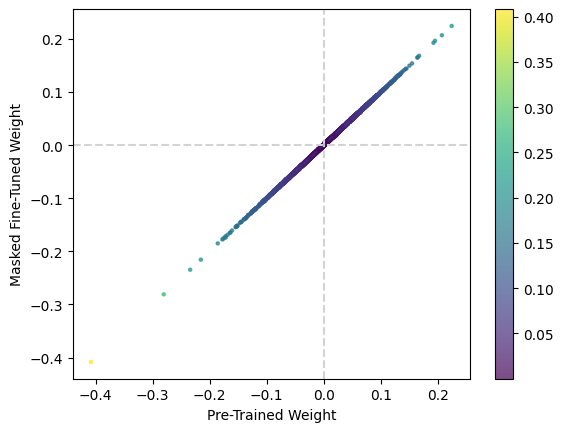

In [160]:
x_subset = untrained_weights_list[random_idx]
y_subset = trained_weights_list[random_idx]
mask_subset = movement_mask_list[random_idx]
score_subset = magnitude_score_list[random_idx]

plt.scatter(x_subset, y_subset, s=5, alpha=0.7, c=score_subset)
plt.axvline(x=0, color='lightgrey', linestyle='--')
plt.axhline(y=0, color='lightgrey', linestyle='--')
plt.xlabel("Pre-Trained Weight")
plt.ylabel("Masked Fine-Tuned Weight")
plt.colorbar()
# plt.xlim((-0.005, 0.005))
# plt.ylim((-0.005, 0.005))
plt.plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.2, linestyle="--")
plt.show()

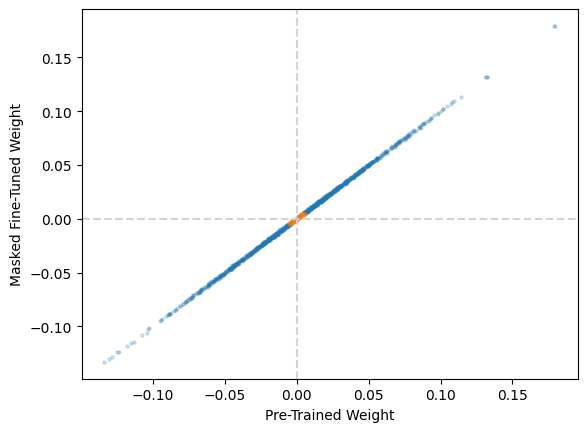

In [89]:
x_subset = untrained_weights_list[random_idx]
y_subset = trained_weights_list[random_idx]
mask_subset = magnitude_mask_list[random_idx]

plt.scatter(x_subset[mask_subset], y_subset[mask_subset], s=5, alpha=0.2)
plt.scatter(x_subset[~mask_subset], y_subset[~mask_subset], s=5, alpha=0.2)
plt.axvline(x=0, color='lightgrey', linestyle='--')
plt.axhline(y=0, color='lightgrey', linestyle='--')
plt.xlabel("Pre-Trained Weight")
plt.ylabel("Masked Fine-Tuned Weight")
plt.plot([-0.05, 0.05], [-0.05, 0.05], alpha=0.2, linestyle="--")

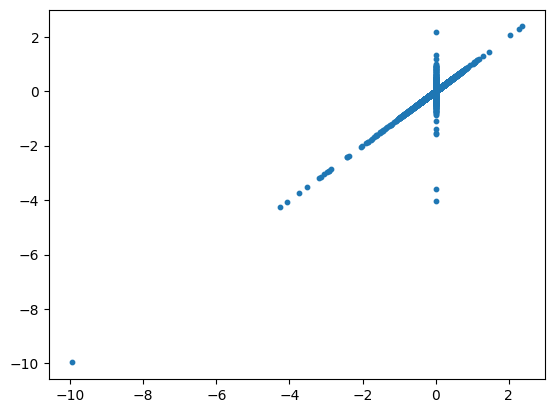

In [72]:
plt.scatter(masked_finetuned_weights_list, trained_weights_list, s=10)

  0%|          | 0/250 [00:00<?, ?it/s]

100%|██████████| 250/250 [00:06<00:00, 39.51it/s]


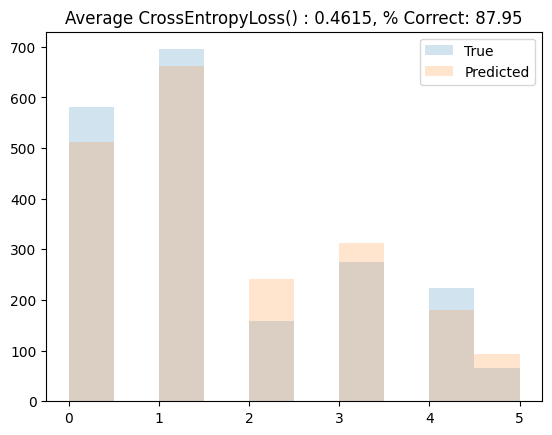

In [13]:
masked_predictions, masked_targets, masked_pred_labels, masked_target_labels, masked_prop_correct, masked_avg_loss = evaluate(masked_model, eval_dataloader, criterion)

In [18]:
weight_removed_list = []
prop_correct_list = []
avg_loss_list = []

for q in tqdm(np.linspace(0.0, 0.15, 16)):
    masked_model = torch.load('distilbert.pt')
    masked_model, percent_weight_removed, mask_list = get_masked_model(masked_model, q)
    masked_finetuned_weights_list = masked_model.get_param_list()
    masked_predictions, masked_targets, masked_pred_labels, masked_target_labels, masked_prop_correct, masked_avg_loss = evaluate(masked_model, eval_dataloader, criterion, plot=False)

    weight_removed_list.append(percent_weight_removed)
    prop_correct_list.append(masked_prop_correct)
    avg_loss_list.append(masked_avg_loss)

100%|██████████| 16/16 [11:43<00:00, 43.95s/it]


In [47]:
# magnitude_weight_removed_list = []
# magnitude_prop_correct_list = []
# magnitude_avg_loss_list = []

for q in tqdm(np.linspace(0.5, 1, 15)):
    masked_model = torch.load('distilbert.pt')
    masked_model, percent_weight_removed, mask_list = get_masked_model(masked_model, q, type="magnitude")
    masked_finetuned_weights_list = masked_model.get_param_list()
    masked_predictions, masked_targets, masked_pred_labels, masked_target_labels, masked_prop_correct, masked_avg_loss = evaluate(masked_model, eval_dataloader, criterion, plot=False)

    magnitude_weight_removed_list.append(percent_weight_removed)
    magnitude_prop_correct_list.append(masked_prop_correct)
    magnitude_avg_loss_list.append(masked_avg_loss)

100%|██████████| 15/15 [04:13<00:00, 16.88s/it]


Text(0.5, 1.0, 'DistillBERT Classification Accuracy vs. Pruning')

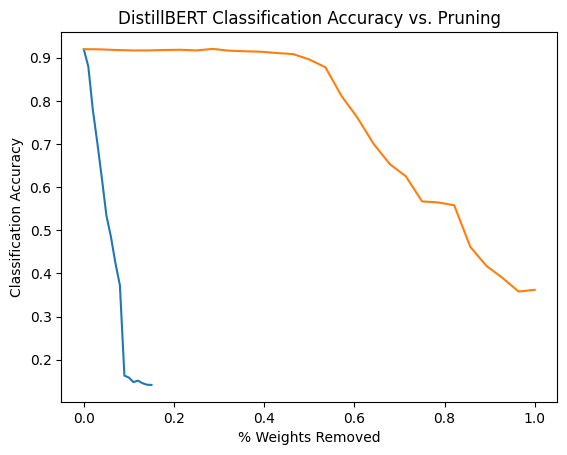

In [48]:
plt.plot(weight_removed_list, prop_correct_list)
plt.plot(magnitude_weight_removed_list, magnitude_prop_correct_list)

plt.xlabel("% Weights Removed")
plt.ylabel("Classification Accuracy")
plt.title("DistillBERT Classification Accuracy vs. Pruning")

Text(0.5, 1.0, 'DistillBERT Classification Accuracy vs. Pruning')

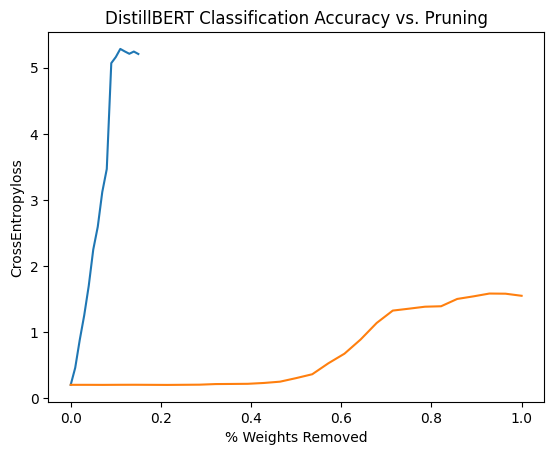

In [91]:
plt.plot(weight_removed_list, avg_loss_list)
plt.plot(magnitude_weight_removed_list, magnitude_avg_loss_list)

plt.xlabel("% Weights Removed")
plt.ylabel("CrossEntropyloss")
plt.title("DistillBERT Classification Accuracy vs. Pruning")

In [22]:
temp_df = pd.DataFrame({"weight_removed": weight_removed_list, "prop_correct": prop_correct_list, type:"Adam"})
temp_df.to_csv("Masked_Model_Performace.csv")